In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Preparing & Visulizing data

In [3]:
img_size = (224, 224)
batch_size = 32

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
rescale = layers.Rescaling(1./255)

In [5]:
def prepare(ds: tf.data.Dataset):
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1024).prefetch(AUTOTUNE).cache()
    
    return ds

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory('chest_xray/train', image_size=img_size, seed=10)
test_ds = tf.keras.utils.image_dataset_from_directory('chest_xray/test', image_size=img_size, seed=10)
val_ds = tf.keras.utils.image_dataset_from_directory('chest_xray/val', image_size=img_size, seed=10)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [7]:
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [37]:
def show_batch(images, labels, pred_labels=None, num=25):
    classes = ['NORMAL', 'PNEUMONIA']
    font_dict = {"color": "black"}
    plt.figure(figsize=(20, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i])

        if (pred_labels is not None):
            if (labels[i] == round(pred_labels[i][0])):
                font_dict['color'] = 'green'
            else:
                font_dict['color'] = 'red'

        plt.title(classes[labels[i]], font_dict)
        plt.axis("off")

In [9]:
train_iter = train_ds.as_numpy_iterator()

In [11]:
images, labels = train_iter.next()

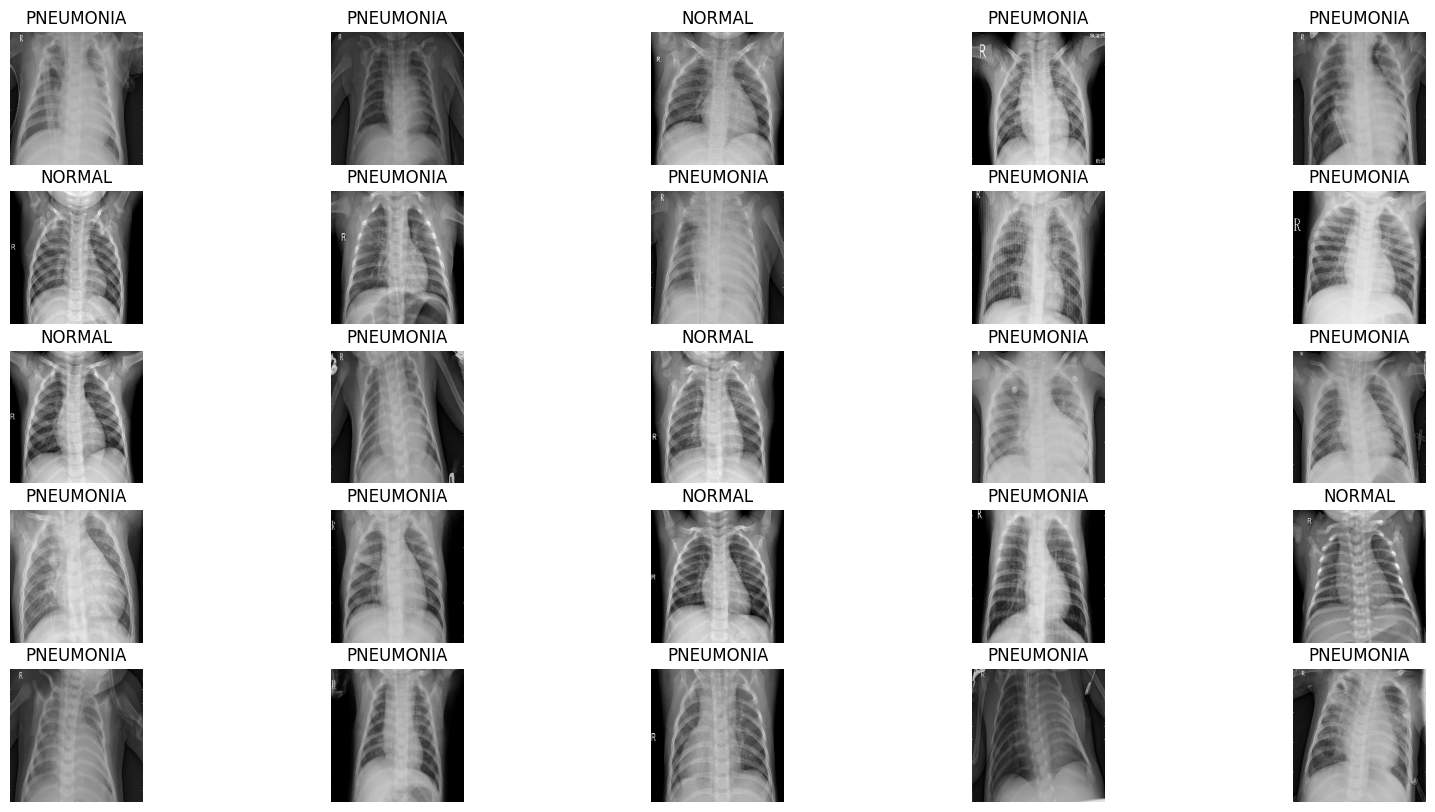

In [12]:
show_batch(images, labels)

In [13]:
TRAIN_NUM = len(train_ds)*batch_size
NORMAL_NUM = 1341
PNEUMONIA_NUM = 3875

In [14]:
normal_weight = (1 / NORMAL_NUM)*(TRAIN_NUM / 2)
pnuemonia_weight = (1 / PNEUMONIA_NUM)*(TRAIN_NUM / 2)

class_weights = {0: normal_weight, 1: pnuemonia_weight}

In [15]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## DL Model

### Data Augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
])

In [17]:
resnet50_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
resnet50_model.trainable = False

In [18]:
model = tf.keras.Sequential([
    layers.Input((*img_size, 3)),
    data_augmentation,
    layers.BatchNormalization(),

    resnet50_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),

    layers.Dense(1, activation="sigmoid")
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                

In [20]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [22]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model/pneumonia.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [23]:
hist = model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[model_checkpoint, early_stopping], class_weight=class_weights)

Epoch 1/100
163/163 [==============================] - 46s 194ms/step - loss: 0.6362 - accuracy: 0.6806 - precision: 0.8678 - recall: 0.6725 - val_loss: 0.5878 - val_accuracy: 0.7067 - val_precision: 0.6852 - val_recall: 0.9821
Epoch 2/100
163/163 [==============================] - 29s 177ms/step - loss: 0.3923 - accuracy: 0.8184 - precision: 0.9342 - recall: 0.8129 - val_loss: 0.5995 - val_accuracy: 0.7244 - val_precision: 0.6989 - val_recall: 0.9821
Epoch 3/100
163/163 [==============================] - 29s 179ms/step - loss: 0.3269 - accuracy: 0.8556 - precision: 0.9519 - recall: 0.8485 - val_loss: 0.3813 - val_accuracy: 0.8317 - val_precision: 0.8276 - val_recall: 0.9231
Epoch 4/100
163/163 [==============================] - 29s 177ms/step - loss: 0.2965 - accuracy: 0.8719 - precision: 0.9583 - recall: 0.8653 - val_loss: 0.3871 - val_accuracy: 0.8237 - val_precision: 0.8125 - val_recall: 0.9333
Epoch 5/100
163/163 [==============================] - 29s 179ms/step - loss: 0.2676 - a

In [24]:
model.evaluate(test_ds)

20/20 [==============================] - 1s 62ms/step - loss: 0.2686 - accuracy: 0.8862 - precision: 0.9143 - recall: 0.9026


[0.26857563853263855,
 0.8862179517745972,
 0.9142857193946838,
 0.9025641083717346]

In [25]:
model.evaluate(val_ds)

1/1 [==============================] - 0s 297ms/step - loss: 0.1840 - accuracy: 0.9375 - precision: 0.8889 - recall: 1.0000


[0.18401679396629333, 0.9375, 0.8888888955116272, 1.0]

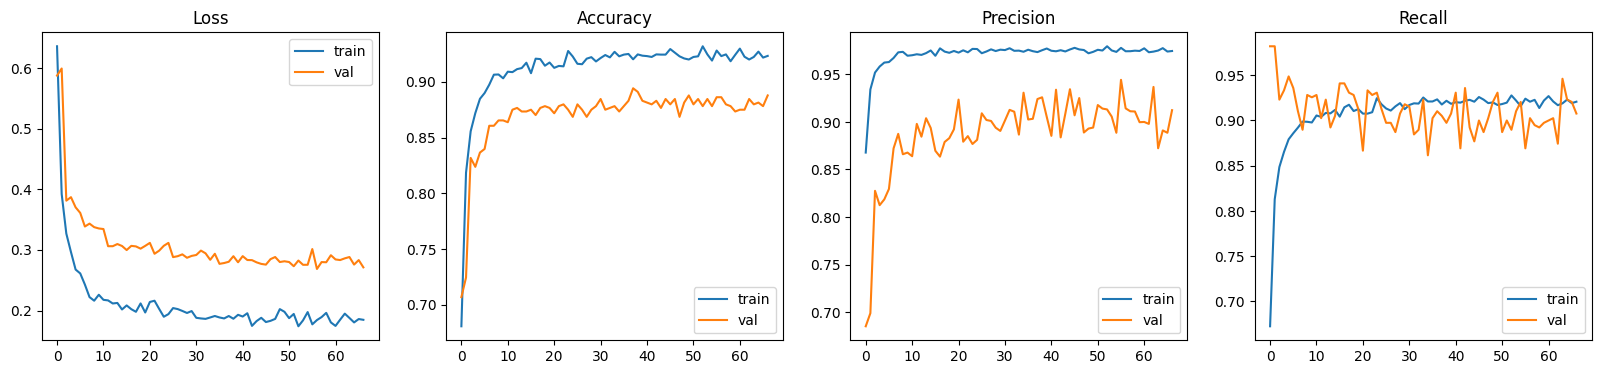

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 4))
for i, m in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(hist.history[m])
    ax[i].plot(hist.history["val_"+m])
    ax[i].set_title(m.title())
    ax[i].legend(['train', 'val'])

In [30]:
test_iter = test_ds.as_numpy_iterator()

In [31]:
test_batch = test_iter.next()

In [32]:
images, labels = test_batch
pred_labels = model.predict(images)

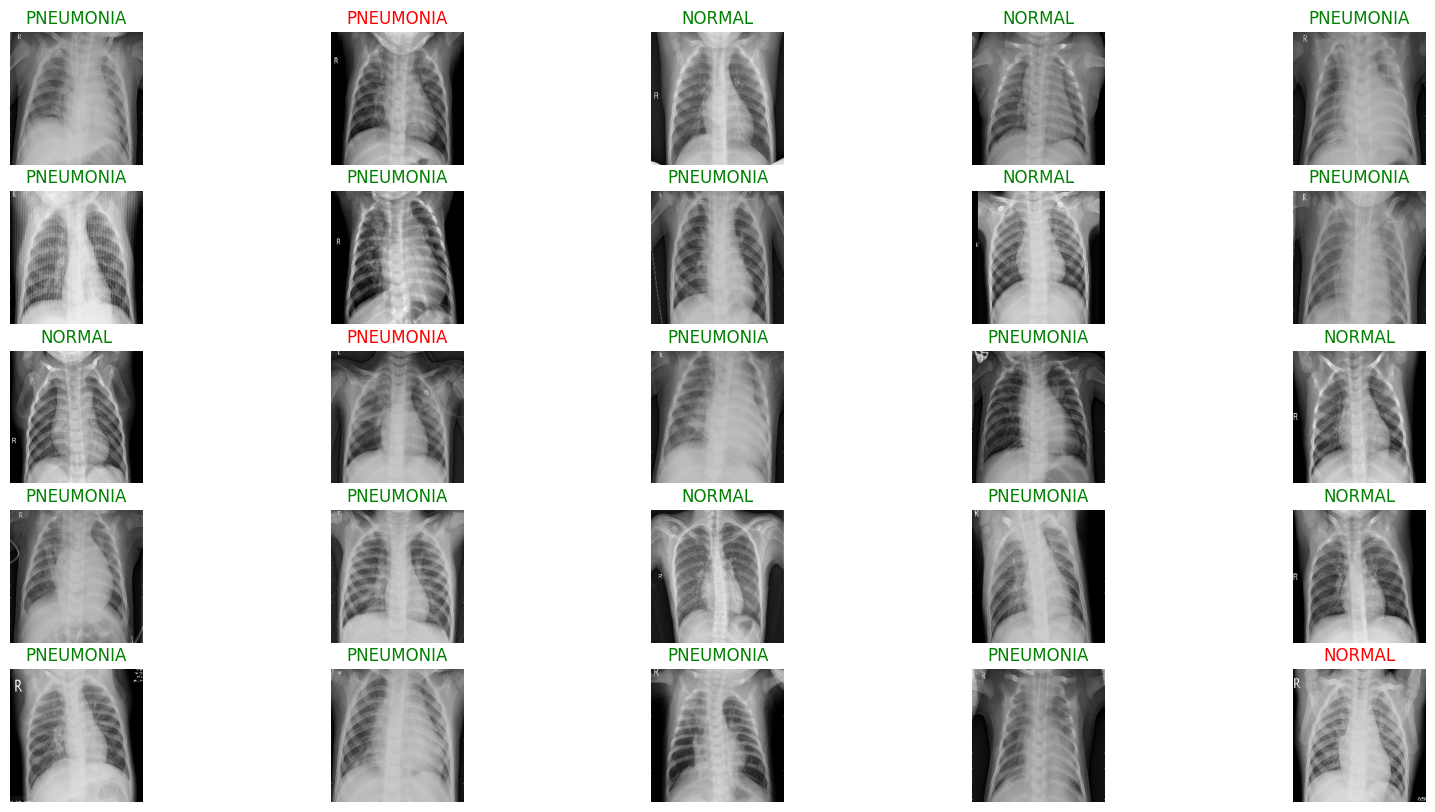

In [38]:
show_batch(images, labels, pred_labels)